# MNIST - Multiclass Classification

## Modules

In [1]:
import sys
import os

common_dir = os.path.abspath('../../common')

if common_dir not in sys.path:
    sys.path.append(common_dir)

print(os.listdir(common_dir))   ## utils.py, tf_trainer.py

['pt_trainer.py', 'tf_trainer.py', 'utils.py', '__pycache__']


In [2]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pylab as plt

from utils import show_images, plot_progress
from tf_trainer import TrainerWithEarlyStopping, accuracy, binary_accuracy
from scipy.special import softmax, expit as sigmoid

os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

## Parameters

In [3]:
import random

manual_seed = 42
random.seed(manual_seed)
np.random.seed(manual_seed)
tf.random.set_seed(manual_seed)

In [4]:
image_size = (28, 28)
n_classes = 10
batch_size = 128
n_epochs = 10

save_model_weights = False
model_weights_name = "./tf_models/tf_mnist_clf-10.h5"

## Data Set

In [5]:
import gzip

def load_mnist(data_dir):
    def load(file_path, offset):
        with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), dtype=np.uint8, offset=offset)
        return data.reshape(-1, 28, 28) if offset == 16 else data
    x_train = load(os.path.join(data_dir, 'train-images-idx3-ubyte.gz'), 16)
    y_train = load(os.path.join(data_dir, 'train-labels-idx1-ubyte.gz'), 8)
    x_test = load(os.path.join(data_dir, 't10k-images-idx3-ubyte.gz'), 16)
    y_test = load(os.path.join(data_dir, 't10k-labels-idx1-ubyte.gz'), 8)

    return (x_train, y_train), (x_test, y_test)

In [6]:
from sklearn.model_selection import train_test_split

data_dir = "/mnt/f/deep_learning/datasets/mnist_11M"
(images, labels), (test_images, test_labels) = load_mnist(data_dir)
train_images, valid_images, train_labels, valid_labels = train_test_split(
    images, labels, train_size=0.8, random_state=21)

print(f">> Train images: {len(train_images)} ({len(train_images)/len(images):.2f})")
print(f">> Valid images: {len(valid_images)} ({len(valid_images)/len(images):.2f})")
print(f">> Test images: {len(test_images)}")

>> Train images: 48000 (0.80)
>> Valid images: 12000 (0.20)
>> Test images: 10000


## Data Loader

In [7]:
def load_data(image, label):
    image = tf.expand_dims(image, axis=-1)
    image = tf.cast(image, dtype=tf.float32)/255
    label = tf.cast(label, dtype=tf.int64)
    return image, label

def get_dataloader(images, labels, batch_size, shuffle=True):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    dataloader = tf.data.Dataset.from_tensor_slices((images, labels)).cache()
    dataloader = dataloader.map(load_data, num_parallel_calls=AUTOTUNE)
    if shuffle:
        dataloader = dataloader.shuffle(1000)
    dataloader = dataloader.batch(batch_size).prefetch(AUTOTUNE)
    return dataloader

train_loader = get_dataloader(train_images, train_labels, batch_size=128, 
                              shuffle=True)
valid_loader = get_dataloader(valid_images, valid_labels, batch_size=128, 
                              shuffle=False)
test_loader = get_dataloader(test_images, test_labels, batch_size=128, 
                             shuffle=False)

<class 'tensorflow.python.framework.ops.EagerTensor'> (128, 28, 28, 1) <dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'> (128,) <dtype: 'int64'>
>> Images: min: 0.0, max: 1.0
>> Labels: min: 0, max: 9


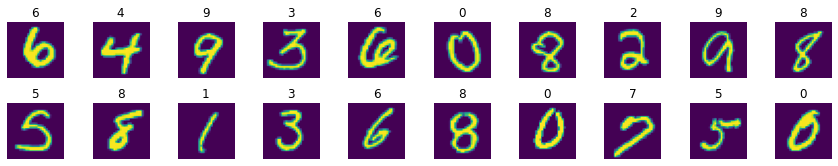

In [9]:
images, labels = next(iter(train_loader))
print(type(images), images.shape, images.dtype)
print(type(labels), labels.shape, labels.dtype)

images = images.numpy()
labels = labels.numpy()
n_samples = 20

print(f">> Images: min: {images.min()}, max: {images.max()}")
print(f">> Labels: min: {labels.min()}, max: {labels.max()}")
show_images(images[:n_samples], labels=labels[:n_samples], n_cols=10) 

## Modeling

In [10]:
from tensorflow.keras import layers

def get_cnn_model(input_shape, n_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(64, (3, 3), strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256)(x)
    x = layers.ReLU()(x)
    outputs = layers.Dense(n_classes)(x)
    return keras.Model(inputs, outputs)

## Training

In [11]:
%%time
from tf_trainer import TrainerWithEarlyStopping, accuracy

model = get_cnn_model(input_shape=(28, 28, 1), n_classes=10)
optimizer = keras.optimizers.Adam()
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, 
                               metrics={'acc':accuracy})
hist = clf.fit(train_loader, n_epochs=100, valid_loader=valid_loader)

if save_model_weights:
    model.save_weights(model_weights_name)

results = clf.evaluate(test_loader)
print(">>", ', '.join([f"test_{key}={value:.4f}" for key, value in results.items()]))

Epoch[  1/100] loss=0.1899, acc=0.9427 | val_loss=0.2146, val_acc=0.9587 (1)                        
Epoch[  2/100] loss=0.0528, acc=0.9832 | val_loss=0.0764, val_acc=0.9758 (1)                        
Epoch[  3/100] loss=0.0309, acc=0.9901 | val_loss=0.0531, val_acc=0.9843 (1)                        
Epoch[  4/100] loss=0.0231, acc=0.9919 | val_loss=0.0469, val_acc=0.9876 (1)                        
Epoch[  5/100] loss=0.0157, acc=0.9951 | val_loss=0.0522, val_acc=0.9863 (2)                        
Epoch[  6/100] loss=0.0125, acc=0.9958 | val_loss=0.0599, val_acc=0.9839 (3)                        
Epoch[  7/100] loss=0.0084, acc=0.9972 | val_loss=0.0517, val_acc=0.9871 (4)                        
Epoch[  8/100] loss=0.0089, acc=0.9971 | val_loss=0.0499, val_acc=0.9874 (5)                        
>> Early stopped! (Best epoch=4)
>> test_loss=0.0394, test_acc=0.9866                                                                
CPU times: user 1min 27s, sys: 52.5 s, total: 2min 20s
Wal

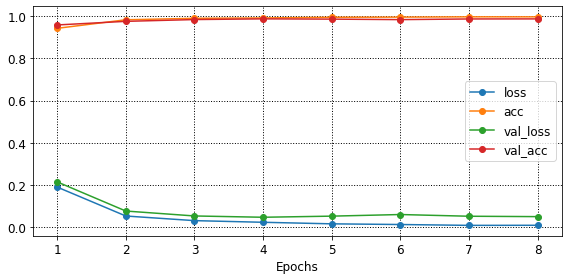

In [12]:
plot_progress(hist)

## Inference

In [ ]:
if save_model_weights:
    model = get_cnn_model(input_shape=(28, 28, 1), n_classes=10)
    model.load_weights(model_weights_name)

4/4 [==============================] - 0s 3ms/step
>> Ground Truth:


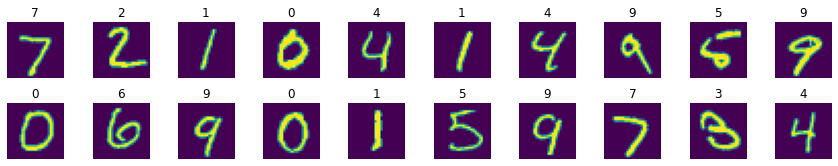

>> Predictions:


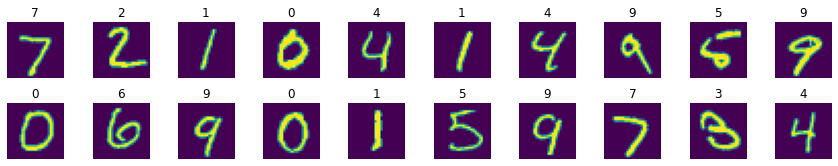

In [14]:
images, labels = next(iter(test_loader))
preds = model.predict(images)

images = images.numpy()
labels = labels.numpy()
preds = softmax(preds).argmax(axis=-1)

n_samples = 20
print(f">> Ground Truth:")
show_images(images[:n_samples], labels=labels[:n_samples], n_cols=10)

print(f">> Predictions:")
show_images(images[:n_samples], labels=preds[:n_samples], n_cols=10)